In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import LabelEncoder
from datetime import datetime, date
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker
import lightgbm as lightgbm

In [2]:
FILES_DIR = './files/'
Eco_df = pd.read_csv(FILES_DIR + 'Eco_df.csv')

In [3]:
Eco_df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
Eco_df.columns

Index(['session_id', 'event_timestamp', 'event_name', 'user_no', 'item_no',
       'device_type', 'country', 'region', 'platform', 'rating', 'birth_date',
       'gender', 'age', 'item_name', 'image_name', 'price', 'category1_code',
       'category1_name', 'category2_code', 'category2_name', 'category3_code',
       'category3_name', 'brand_no', 'brand_name', 'dayname', 'korea',
       'cor_cat1', 'cor_region', 'Hour', 'time_1', 'time_2', 'time_3'],
      dtype='object')

In [24]:
data = Eco_df.copy()

In [38]:
object_df = data.select_dtypes("object")
object_df.columns

Index(['session_id', 'event_timestamp', 'event_name', 'user_no', 'item_no',
       'device_type', 'country', 'region', 'platform', 'birth_date', 'gender',
       'item_name', 'image_name', 'category1_name', 'category2_name',
       'category3_name', 'brand_name', 'dayname'],
      dtype='object')

In [39]:
data_drop_col = data.drop(object_df, axis=1)

In [40]:
data_drop_col

,rating,age,price,category1_code,category2_code,category3_code,brand_no,korea,cor_cat1,cor_region,Hour,time_1,time_2,time_3
0,0.1,30,80000.0,243100100,243104100,243104101,1707.0,1,0.0,0.0,21,0,0,0
1,0.1,25,168000.0,243100100,243103100,243103102,3839.0,1,0.0,0.0,10,0,1,0
2,0.1,30,69900.0,243100100,243103100,243103101,10214.0,1,0.0,0.0,11,0,1,0
3,0.1,25,78000.0,244100100,244109100,244109104,3094.0,1,0.0,0.0,1,0,0,0
4,0.1,30,132000.0,244100100,244102100,244102107,2867.0,1,0.0,0.0,21,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16364,0.3,30,48000.0,244100100,244108100,244108102,5221.0,1,0.0,0.0,22,0,0,0
16365,0.1,25,59000.0,243100100,243102100,243102102,2427.0,1,0.0,0.0,23,0,0,0
16366,0.1,30,74000.0,244100100,244102100,244102104,6060.0,1,0.0,0.0,1,0,0,0
16367,0.1,30,46000.0,243100100,243102100,243102103,2672.0,1,0.0,0.0,12,0,1,0


In [70]:
for i in object_df.columns:
    label = LabelEncoder()
    label.fit(object_df[i])
    object_df[i] = label.transform(object_df[i])
object_df

,session_id,event_timestamp,event_name,user_no,item_no,device_type,country,region,platform,birth_date,gender,item_name,image_name,category1_name,category2_name,category3_name,brand_name,dayname
0,11507,2814,1,10173,4595,0,8,14,0,2828,0,1377,1432,7,78,105,640,1
1,14489,6612,1,8377,12258,1,8,13,1,6416,2,3432,13,7,51,264,1189,5
2,10020,8030,1,8107,701,0,8,32,1,4701,2,11466,9289,7,51,229,1009,3
3,7469,15780,1,13214,9744,0,8,32,1,6454,0,6674,8372,8,65,84,1095,1
4,6639,15449,1,9173,2235,0,8,12,1,4319,0,2411,9435,8,2,404,474,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16364,5505,10226,0,1754,10433,0,8,32,0,2674,1,3964,6429,8,20,125,1521,3
16365,11281,9365,1,10204,9539,0,8,32,1,5405,0,3303,10176,7,27,303,703,4
16366,7197,10584,1,2352,4880,0,8,12,1,4451,0,7343,7998,8,2,344,1370,5
16367,14425,7185,1,11184,3910,0,8,32,1,3750,0,5939,9653,7,27,348,389,4


In [250]:
label_df = pd.concat([data_drop_col, object_df], axis=1)
label_df 

,rating,age,price,category1_code,category2_code,category3_code,brand_no,korea,cor_cat1,cor_region,...,platform,birth_date,gender,item_name,image_name,category1_name,category2_name,category3_name,brand_name,dayname
0,0.1,30,80000.0,243100100,243104100,243104101,1707.0,1,0.0,0.0,...,0,2828,0,1377,1432,7,78,105,640,1
1,0.1,25,168000.0,243100100,243103100,243103102,3839.0,1,0.0,0.0,...,1,6416,2,3432,13,7,51,264,1189,5
2,0.1,30,69900.0,243100100,243103100,243103101,10214.0,1,0.0,0.0,...,1,4701,2,11466,9289,7,51,229,1009,3
3,0.1,25,78000.0,244100100,244109100,244109104,3094.0,1,0.0,0.0,...,1,6454,0,6674,8372,8,65,84,1095,1
4,0.1,30,132000.0,244100100,244102100,244102107,2867.0,1,0.0,0.0,...,1,4319,0,2411,9435,8,2,404,474,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16364,0.3,30,48000.0,244100100,244108100,244108102,5221.0,1,0.0,0.0,...,0,2674,1,3964,6429,8,20,125,1521,3
16365,0.1,25,59000.0,243100100,243102100,243102102,2427.0,1,0.0,0.0,...,1,5405,0,3303,10176,7,27,303,703,4
16366,0.1,30,74000.0,244100100,244102100,244102104,6060.0,1,0.0,0.0,...,1,4451,0,7343,7998,8,2,344,1370,5
16367,0.1,30,46000.0,243100100,243102100,243102103,2672.0,1,0.0,0.0,...,1,3750,0,5939,9653,7,27,348,389,4


In [251]:
label_df['rating'] = label_df['event_name']
re_name = {'rating' : {'click_item':1, 'like_item':2, 'add_to_cart':3, 'purchase_success':4}}
label_df = label_df.replace(re_name)
label_df = label_df[:13000]

In [252]:
y = label_df['rating'].astype(int)
X = label_df.drop('rating', axis=1)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [254]:
query_train = [X_train.shape[0]]
# query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]

In [255]:
query_train

[9750]

In [256]:
thresholds = [1,2,3,4]

In [257]:
model = LGBMRanker(n_estimators=100,
                   objective="lambdarank",
                   random_state=42,
                   num_leaves=41,
                   learning_rate=0.01,
                   max_depth=10,
                   n_jobs=-1)

In [258]:
model.fit(X_train, y_train, 
          group=query_train,
          eval_set=[(X_test, y_test)], 
          eval_group=[query_test],
          eval_at=thresholds,
          eval_metric=['ndcg'])

[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[3]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[4]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[5]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[6]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[7]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[8]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[9]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[10]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[11]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1
[12]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's

LGBMRanker(learning_rate=0.01, max_depth=10, num_leaves=41,
           objective='lambdarank', random_state=42)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

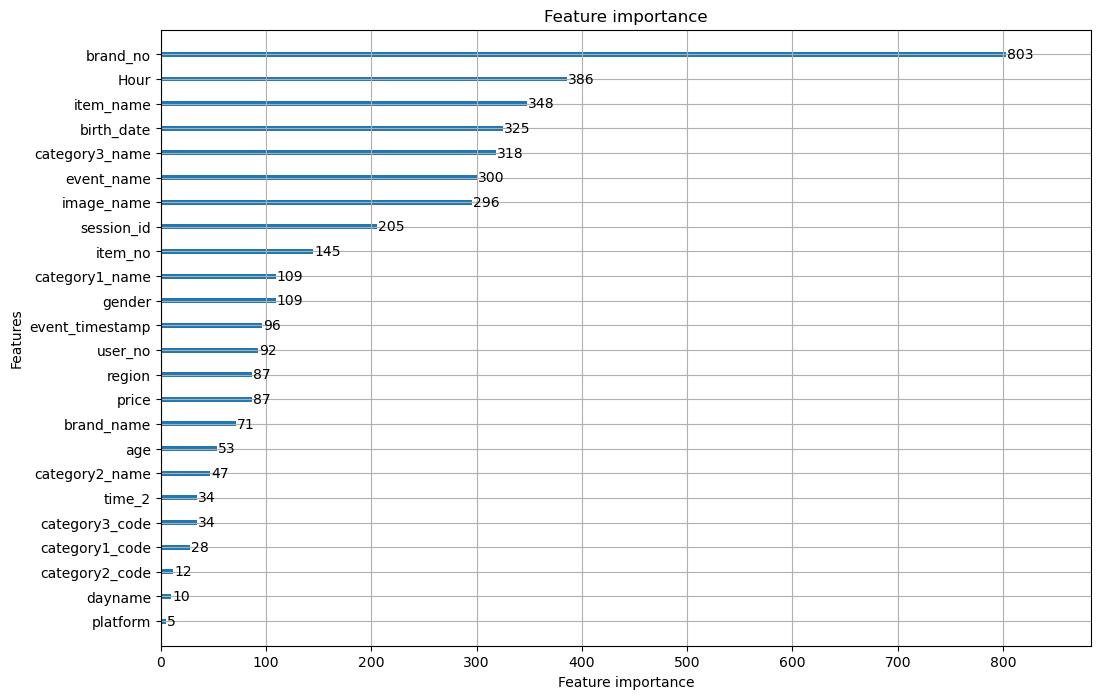

In [259]:
lightgbm.plot_importance(model, figsize = (12,8))

In [260]:
test_pred = model.predict(X_test)


In [261]:
X_test["predicted_ranking"] = test_pred
X_test.sort_values("predicted_ranking", ascending=False)

,age,price,category1_code,category2_code,category3_code,brand_no,korea,cor_cat1,cor_region,Hour,...,birth_date,gender,item_name,image_name,category1_name,category2_name,category3_name,brand_name,dayname,predicted_ranking
4031,25,50000.0,243100100,243104100,243104101,2047.0,1,0.0,0.0,9,...,5353,0,6661,185,7,78,105,24,4,1.315590
3065,25,54900.0,244100100,244101100,244101112,10557.0,1,0.0,0.0,16,...,5050,0,11735,4206,8,41,190,319,1,1.315589
316,20,48000.0,243100100,243102100,243102103,3774.0,1,0.0,0.0,16,...,6649,1,4121,203,7,27,348,635,5,1.315589
2435,30,20000.0,249100100,249105100,249105105,14065.0,1,0.0,0.0,7,...,2296,1,10696,5172,6,52,286,2130,6,1.315589
5284,25,112000.0,244100100,244104100,244104102,6418.0,1,0.0,0.0,8,...,5791,0,5650,39,8,44,152,1021,5,1.315589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,40,39000.0,243100100,243102100,243102103,8118.0,1,0.0,0.0,7,...,87,0,5483,95,7,27,348,1359,2,-1.314807
3409,30,99000.0,244100100,244101100,244101101,14019.0,1,0.0,0.0,19,...,4857,0,7907,8707,8,41,366,1657,4,-1.314807
214,30,27500.0,243100100,243102100,243102103,2649.0,1,0.0,0.0,14,...,2519,1,9039,11927,7,27,348,1312,2,-1.314807
1597,40,386000.0,244100100,244101100,244101110,2987.0,1,0.0,0.0,22,...,849,0,7712,5857,8,41,126,719,1,-1.314807


In [262]:
def NDCG(selected,ordered):
    from tqdm import tqdm
    DCG = 0
    iDCG = 0
    
    selected_result = ((np.array(selected) - 1)==0)
    for idx, (i,k) in tqdm(enumerate(zip(selected_result,ordered))):
        if i==True:
            DCG += ((max(ordered) - (k-1)) / (np.log2(idx+1 + 1)))
            
    cum_index = 0
    for idx, i in tqdm(enumerate(range(sum(selected)))):
        iDCG += ((len(selected) - cum_index) / (np.log2(idx+1 + 1)))
        cum_index += 1
    
    NDCG = DCG / iDCG
    
    return NDCG

In [263]:
len(set(test_pred))

438

In [264]:
NDCG(y_test, y_test)

3250it [00:00, 4838.95it/s]
3706it [00:00, 265515.79it/s]


0.0014159574186491147